# 1. Problema

Um grupo de investidores imobiliários precisa saber a previsão de preços de m2 de venda dos ativos (imóveis) para os próximos 12 meses na região do Porto em Portugal.

Eles buscam maximizar o retorno das operações (compra/venda) sobre estes ativos (imóveis) por meio de um sistema preditivo.

A solução deve usar dados públicos e oficiais de instituições portuguesas e apresentar a média de previsão de venda do m2 por meio de uma linha temporal.

Caso não seja oneroso, criar filtros por região e tipo de imóvel.

# 2. Obtenção dos dados

Dados usados neste modelo preditivo:

## 2.1. Dados Históricos de Preços de Imóveis

Dados históricos sobre os preços de venda de imóveis na região do Porto, disponíveis de forma granular, com uma série temporal consistente de, pelo menos, alguns anos para capturar as tendências.

**i - Valor médio de vendas por m2:**
- Instituição: Instituto Nacional de Estatística - Portugal
- fonte original: https://www.ine.pt/xportal/xmain?xpid=INE&xpgid=ine_indicadores&indOcorrCod=0012227&contexto=bd&selTab=tab2
- fonte local : csv/Hhi6wqTMrXx5sHqSPnHjc99gSsxDGkkjMSDmKYiC 60780.csv


## 2.2. Indicadores econômicos

Fatores macroeconômicos têm um impacto significativo no mercado imobiliário. 

Incluir dados que refletem o estado da economia na região.

**i - Taxa de juro (TAA) de novos empréstimos à habitação**
- Instituição: Banco de Portugal
- fonte original: https://bpstat.bportugal.pt/serie/12533735

**ii - IPC total (taxa de inflação média anual)**
- Instituição: Banco de Portugal
- fonte original: https://bpstat.bportugal.pt/serie/5721550

**iii - Índice de Preços de habitação**
- Instituição: Banco de Portugal
- fonte original: https://bpstat.bportugal.pt/dominios/39

**iv - taxa de desemprego**
- Instituição: Banco de Portugal
- fonte original: https://bpstat.bportugal.pt/serie/5739374

# 3 - Pré-processamento de dados

Limpeza e transformação dos dados, que pode incluir a remoção de valores ausentes, normalização, padronização, codificação de variáveis categóricas, etc


## 3.1 -  Tabela de ingestão de dados

Foi criado manualmente uma tabela única contemplando os dados descritos em 2.1 e 2.2.

- csv/data_source_tc03.csv


Numa segunda fase, esta tabela será criada num serviço de nuvem e processada por jobs ETL para extração, transformação e load dos dados, constituindo a "camada bronze" do modelo.

In [1]:
import pandas as pd
import requests
from io import StringIO
import numpy as np


In [2]:
# URL do CSV diretamente do GitHub (arquivo bruto)
file_path = "https://raw.githubusercontent.com/rivolela/fiap_tech_challenge_03/ae57bb6cd423c7b38a3208c9b6ea112d168d1344/csv/data_source_tech_challenge_03.csv"

# Baixar o arquivo CSV
response = requests.get(file_path, verify=True)

# Verificar se a requisição foi bem-sucedida
if response.status_code == 200:
    # Ler o CSV usando o delimitador correto
    df = pd.read_csv(StringIO(response.text), delimiter=',', quotechar='"', engine='python', on_bad_lines='skip')

    # Limpar os nomes das colunas removendo espaços em branco antes ou depois dos nomes
    df.columns = df.columns.str.strip()

    # Colunas que precisam ser convertidas para float
    colunas_para_converter = [
        'valor_m2_novo', 'valor_m2_existente', 'taxa_inflacao_nacional',
        'taxa_juros_emprestimo_nacional', 'indice_preco_habitacao_alojamento_novo',
        'indice_preco_habitacao_alojamento_existente', 'taxa_desemprego_16_a_74_anos'
    ]

    # Converter as colunas para float, lidando com erros
    for coluna in colunas_para_converter:
        df[coluna] = pd.to_numeric(df[coluna], errors='coerce')

    print(df.info)        
else:
    print(f"Erro ao baixar o arquivo: {response.status_code}")


<bound method DataFrame.info of                                                 Bairro Periodo  valor_m2_novo  \
0                                               Bonfim  2019T4         2574.0   
1                                             Campanhã  2019T4         1789.0   
2                                             Paranhos  2019T4         1865.0   
3                                              Ramalde  2019T4         1759.0   
4    União das freguesias de Aldoar, Foz do Douro e...  2019T4         3351.0   
..                                                 ...     ...            ...   
121                                           Paranhos  2024T1         3214.0   
122                                            Ramalde  2024T1         2823.0   
123  União das freguesias de Aldoar, Foz do Douro e...  2024T1         4944.0   
124  União das freguesias de Cedofeita, Santo Ildef...  2024T1         3835.0   
125  União das freguesias de Lordelo do Ouro e Mass...  2024T1         3701.0

## 3.2 - Limpar dados nulos

In [3]:
# Drop rows with null values

# Create a mask to identify rows with null values
null_rows = df[df.isnull().any(axis=1)]

df_clean = df.dropna()

# Print the rows that were removed
print("Rows removed due to null values:")
print(null_rows)

print(df_clean.head)


Rows removed due to null values:
      Bairro Periodo  valor_m2_novo  valor_m2_existente  \
22  Campanhã  2020T3            NaN                1250   
29  Campanhã  2020T4            NaN                1351   

    taxa_inflacao_nacional  taxa_juros_emprestimo_nacional  \
22                    0.10                            1.00   
29                    0.03                            0.84   

    indice_preco_habitacao_alojamento_novo  \
22                                  136.57   
29                                  140.27   

    indice_preco_habitacao_alojamento_existente  taxa_desemprego_16_a_74_anos  
22                                       159.44                           8.0  
29                                       163.64                           7.3  
<bound method NDFrame.head of                                                 Bairro Periodo  valor_m2_novo  \
0                                               Bonfim  2019T4         2574.0   
1                              

## 3.3 - Tratamento de colunas numéricas

In [4]:
# Limpar os nomes das colunas removendo espaços em branco antes ou depois dos nomes
df_clean.columns = df_clean.columns.str.strip()

# Lista das colunas que queremos converter para números
colunas_numericas = [
    'valor_m2_novo', 'valor_m2_existente', 'taxa_inflacao_nacional',
    'taxa_juros_emprestimo_nacional', 'indice_preco_habitacao_alojamento_novo',
    'indice_preco_habitacao_alojamento_existente', 'taxa_desemprego_16_a_74_anos'
]

# Substituir vírgulas por pontos e converter para float
for coluna in colunas_numericas:
    # Verifica se a coluna está no DataFrame
    if coluna in df_clean.columns:
        # Verifica se a coluna é do tipo 'object' (string)
        if df_clean[coluna].dtype == 'object':
            df_clean.loc[:, coluna] = df_clean[coluna].str.replace(',', '.').astype(float)
        else:
            df_clean.loc[:, coluna] = df_clean[coluna].astype(float)  # Já pode converter diretamente
    else:
        print(f"Coluna {coluna} não encontrada no DataFrame.")

# Exibir as primeiras linhas para verificar a conversão
print(df_clean[colunas_numericas].head())


   valor_m2_novo  valor_m2_existente  taxa_inflacao_nacional  \
0         2574.0                1705                    0.37   
1         1789.0                1231                    0.37   
2         1865.0                1534                    0.37   
3         1759.0                1592                    0.37   
4         3351.0                2453                    0.37   

   taxa_juros_emprestimo_nacional  indice_preco_habitacao_alojamento_novo  \
0                            1.06                                  130.27   
1                            1.06                                  130.27   
2                            1.06                                  130.27   
3                            1.06                                  130.27   
4                            1.06                                  130.27   

   indice_preco_habitacao_alojamento_existente  taxa_desemprego_16_a_74_anos  
0                                       151.48                           

## 3.4 - Removendo Outliers

In [5]:
# Função para detectar e tratar outliers usando o método IQR
def tratar_outliers_iqr(df, colunas_numericas):
    for coluna in colunas_numericas:
        if coluna in df.columns:
            # Calcular os quartis
            Q1 = df[coluna].quantile(0.25)
            Q3 = df[coluna].quantile(0.75)
            IQR = Q3 - Q1
            
            # Definir limites inferior e superior
            limite_inferior = Q1 - 1.5 * IQR
            limite_superior = Q3 + 1.5 * IQR
            
            # Criar uma cópia da coluna original para comparação
            original_values = df[coluna].copy()
            
            # Imprimir limites para verificação
            print(f"Coluna: {coluna}, Limite Inferior: {limite_inferior}, Limite Superior: {limite_superior}")
            
            # Contar os outliers antes de tratar
            outliers_count_before = ((original_values < limite_inferior) | (original_values > limite_superior)).sum()
            print(f"Número de outliers antes de tratamento: {outliers_count_before}")

            # Substituir outliers acima do limite superior com o limite superior usando .loc
            df.loc[df[coluna] > limite_superior, coluna] = limite_superior
            
            # Substituir outliers abaixo do limite inferior com o limite inferior usando .loc
            df.loc[df[coluna] < limite_inferior, coluna] = limite_inferior
            
            # Contar os outliers após tratar
            outliers_count_after = ((df[coluna] < limite_inferior) | (df[coluna] > limite_superior)).sum()
            print(f"Número de outliers após tratamento: {outliers_count_after}")

            # Identificar quais valores foram atualizados
            updated_items = df[df[coluna] != original_values]
            
            print(f"Outliers tratados na coluna {coluna}")
            if not updated_items.empty:
                print("Valores atualizados:")
                print(updated_items[[coluna]])  # Mostrar apenas a coluna atualizada
            else:
                print("Nenhum valor foi atualizado na coluna.")
        else:
            print(f"Coluna {coluna} não encontrada no DataFrame.")

    return df



# Aplicar a função ao DataFrame
df_tratado = tratar_outliers_iqr(df_clean, colunas_numericas)

# Exibir o resultado
#print(df_tratado[colunas_numericas].describe())


Coluna: valor_m2_novo, Limite Inferior: 1296.125, Limite Superior: 4779.125
Número de outliers antes de tratamento: 1
Número de outliers após tratamento: 0
Outliers tratados na coluna valor_m2_novo
Valores atualizados:
     valor_m2_novo
123       4779.125
Coluna: valor_m2_existente, Limite Inferior: 670.75, Limite Superior: 3528.75
Número de outliers antes de tratamento: 3
Número de outliers após tratamento: 0
Outliers tratados na coluna valor_m2_existente
Valores atualizados:
     valor_m2_existente
109             3528.75
116             3528.75
123             3528.75
Coluna: taxa_inflacao_nacional, Limite Inferior: -7.495, Limite Superior: 13.025
Número de outliers antes de tratamento: 0
Número de outliers após tratamento: 0
Outliers tratados na coluna taxa_inflacao_nacional
Nenhum valor foi atualizado na coluna.
Coluna: taxa_juros_emprestimo_nacional, Limite Inferior: -3.2249999999999996, Limite Superior: 7.614999999999999
Número de outliers antes de tratamento: 1
Número de outli

/var/folders/nj/m_h5cgyd6z3b2jy59pdv92p00000gn/T/ipykernel_48590/3004630448.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3528.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[coluna] > limite_superior, coluna] = limite_superior


## 3.5 - Normalização e Padronização

 Ajustar a escala dos dados para facilitar a interpretação  e  o  aprendizado  do  modelo.  Dados  com  escalas  diferentes podem  dificultar  o  aprendizado  do  modelo,  pois  algoritmos  tendem  a  dar mais peso a características com valores maiores.


 - Normalização: ajusta os dados para um intervalo específico, como entre 0 e 1.

 - Padronização: ajusta os dados com média 0 e desvio padrão

### Features que Devem Ser Normalizadas
    
- **taxa_inflacao_nacional:**
    - Intervalo: -0.03 a 8.5 (considerando os limites encontrados)
    - Os dados podem ter uma distribuição diferente e devem ser normalizados.

- **taxa_juros_emprestimo_nacional:**
    - Intervalo: 0.79 a 7.615
    - Com variação significativa, é recomendável normalizar esta coluna.

- **taxa_desemprego_16_a_74_anos:**
    - Intervalo: 5.7 a 8.0
    - Embora a variação não seja tão ampla quanto as anteriores, a normalização ainda pode ser benéfica, especialmente se for utilizado um algoritmo sensível à escala.

In [6]:
from sklearn.preprocessing import StandardScaler

# Defina as colunas que você deseja normalizar
colunas_a_normalizar = [
    'taxa_inflacao_nacional',
    'taxa_juros_emprestimo_nacional',
    'taxa_desemprego_16_a_74_anos'
]

# Inicializar o escalador
scaler = StandardScaler()

# Use .loc para garantir que estamos alterando o DataFrame corretamente
df_normalizado = df_tratado.copy()  # Melhor prática: faça uma cópia do DataFrame original
df_normalizado.loc[:, colunas_a_normalizar] = scaler.fit_transform(df_tratado[colunas_a_normalizar])

# Exibir o DataFrame normalizado
print(df_normalizado[colunas_a_normalizar].head())
print(df_normalizado)


   taxa_inflacao_nacional  taxa_juros_emprestimo_nacional  \
0               -0.846304                       -0.663181   
1               -0.846304                       -0.663181   
2               -0.846304                       -0.663181   
3               -0.846304                       -0.663181   
4               -0.846304                       -0.663181   

   taxa_desemprego_16_a_74_anos  
0                      0.543188  
1                      0.543188  
2                      0.543188  
3                      0.543188  
4                      0.543188  
                                                Bairro Periodo  valor_m2_novo  \
0                                               Bonfim  2019T4       2574.000   
1                                             Campanhã  2019T4       1789.000   
2                                             Paranhos  2019T4       1865.000   
3                                              Ramalde  2019T4       1759.000   
4    União das freguesia

## 3.6 - Codificação de Dados Categóricos

Converter  dados  categóricos  em valores numéricos que os algoritmos possam entender.

1. **Variável Periodo** (e.g., 2019T4, 2020T2, etc.)
O Periodo refere-se a uma sequência temporal, com anos e trimestres (T1, T2, T3, T4). Nesse caso, a ordem dos períodos importa, pois há uma relação sequencial entre eles. Para variáveis temporais com ordem, a melhor abordagem seria:

Codificação de label encoding (codificação ordinal): cada período pode ser mapeado para um número inteiro, refletindo a ordem cronológica. Isso preserva a relação temporal entre os períodos (e.g., 2019T4 pode ser codificado como 1, 2020T1 como 2, e assim por diante).

2. **Variável Bairro** (e.g., Bonfim, Campanhã, etc.)
Bairro é uma variável categórica nominal, ou seja, não existe uma ordem natural entre os bairros. Nesse caso, as abordagens mais comuns são:

Codificação one-hot encoding: transforma a variável Bairro em uma série de colunas binárias, com 1 indicando a presença de um bairro específico e 0 para os demais. Essa abordagem é a mais comum para variáveis nominais sem ordem, pois evita introduzir uma hierarquia artificial entre os bairros

In [7]:
from sklearn.preprocessing import LabelEncoder

# 1. Codificação do Periodo usando Label Encoding
label_encoder = LabelEncoder()
df_normalizado['Periodo_encoded'] = label_encoder.fit_transform(df_normalizado['Periodo'])

# Verificar se a coluna 'Bairro' existe antes de aplicar One-Hot Encoding
if 'Bairro' in df_normalizado.columns:
    # 2. Codificação do Bairro usando One-Hot Encoding
    df_normalizado = pd.get_dummies(df_normalizado, columns=['Bairro'], prefix='Bairro')
else:
    print("Coluna 'Bairro' não encontrada no DataFrame")

# 3. Convertendo colunas booleanas resultantes para inteiros (0 e 1)
# Converter apenas as colunas que podem ser convertidas para inteiros
df_normalizado.loc[:, df_normalizado.columns.str.startswith('Bairro')] = df_normalizado.loc[:, df_normalizado.columns.str.startswith('Bairro')].astype(int)

# Exibir o DataFrame com as colunas codificadas
print(df_normalizado)

# Validação: Conferir as colunas codificadas
print("Colunas após codificação:")
print(df_normalizado.columns)

# Validação: Mostrar os primeiros registros
print("Primeiros registros do DataFrame:")
print(df_normalizado.head())


    Periodo  valor_m2_novo  valor_m2_existente  taxa_inflacao_nacional  \
0    2019T4       2574.000             1705.00               -0.846304   
1    2019T4       1789.000             1231.00               -0.846304   
2    2019T4       1865.000             1534.00               -0.846304   
3    2019T4       1759.000             1592.00               -0.846304   
4    2019T4       3351.000             2453.00               -0.846304   
..      ...            ...                 ...                     ...   
121  2024T1       3214.000             2395.00                0.123922   
122  2024T1       2823.000             2520.00                0.123922   
123  2024T1       4779.125             3528.75                0.123922   
124  2024T1       3835.000             2831.00                0.123922   
125  2024T1       3701.000             2797.00                0.123922   

     taxa_juros_emprestimo_nacional  indice_preco_habitacao_alojamento_novo  \
0                         -0.663

/var/folders/nj/m_h5cgyd6z3b2jy59pdv92p00000gn/T/ipykernel_48590/3273622609.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 0 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_normalizado.loc[:, df_normalizado.columns.str.startswith('Bairro')] = df_normalizado.loc[:, df_normalizado.columns.str.startswith('Bairro')].astype(int)
/var/folders/nj/m_h5cgyd6z3b2jy59pdv92p00000gn/T/ipykernel_48590/3273622609.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 

## 3.7 - Engenharia de features

Criar  novas  features  a  partir  das existentes, extraindo informações adicionais dos dados, caso necessário.

### 3.7.1 - media_valor_m2
Criar nova feature 'media_valor_m2' que é a média entre 'valor_m2_novo' e 'valor_m2_existente'.
A feature 'media_valor_m2' será o target do modelo.


In [8]:
# Criar uma nova coluna 'media_valor_m2' que é a média entre 'valor_m2_novo' e 'valor_m2_existente'
df_normalizado['media_valor_m2'] = (df_normalizado['valor_m2_novo'] + df_normalizado['valor_m2_existente']) / 2

# Exibir o DataFrame com a nova feature
print(df_normalizado)

    Periodo  valor_m2_novo  valor_m2_existente  taxa_inflacao_nacional  \
0    2019T4       2574.000             1705.00               -0.846304   
1    2019T4       1789.000             1231.00               -0.846304   
2    2019T4       1865.000             1534.00               -0.846304   
3    2019T4       1759.000             1592.00               -0.846304   
4    2019T4       3351.000             2453.00               -0.846304   
..      ...            ...                 ...                     ...   
121  2024T1       3214.000             2395.00                0.123922   
122  2024T1       2823.000             2520.00                0.123922   
123  2024T1       4779.125             3528.75                0.123922   
124  2024T1       3835.000             2831.00                0.123922   
125  2024T1       3701.000             2797.00                0.123922   

     taxa_juros_emprestimo_nacional  indice_preco_habitacao_alojamento_novo  \
0                         -0.663

# 4 - Divisão dos Dados e Seleção das Características

Escolha das características (features) mais relevantes para o modelo.

Separação os dados em conjuntos de treino, validação e teste.



0    2139.5
1    1510.0
2    1699.5
3    1675.5
4    2902.0
Name: media_valor_m2, dtype: float64
Periodo                                                                                           0
valor_m2_novo                                                                                     0
valor_m2_existente                                                                                0
taxa_inflacao_nacional                                                                            0
taxa_juros_emprestimo_nacional                                                                    0
indice_preco_habitacao_alojamento_novo                                                            0
indice_preco_habitacao_alojamento_existente                                                       0
taxa_desemprego_16_a_74_anos                                                                      0
Periodo_encoded                                                                                   0
Bai

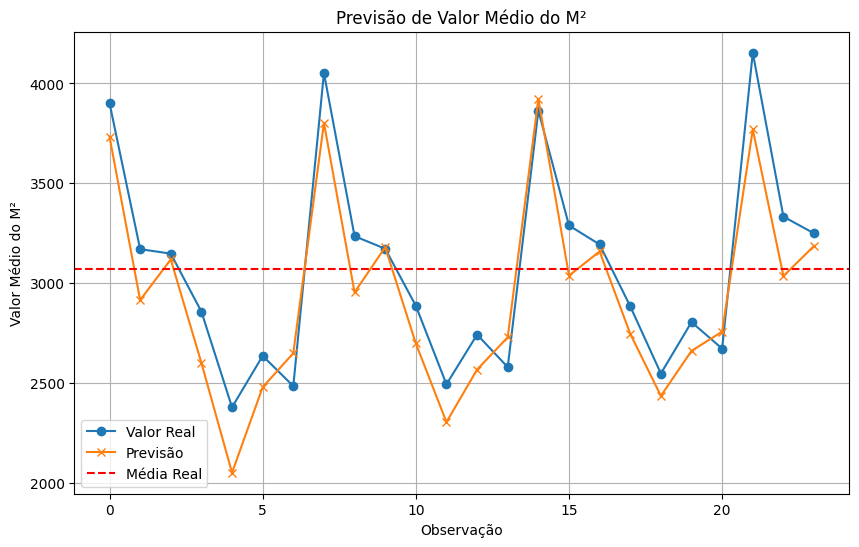

    Periodo  valor_m2_novo  valor_m2_existente  taxa_inflacao_nacional  \
7    2020T1       2591.000             1705.00               -0.859416   
8    2020T1       2068.000             1209.00               -0.859416   
9    2020T1       1861.000             1577.00               -0.859416   
10   2020T1       1643.000             1667.00               -0.859416   
11   2020T1       3766.000             2473.00               -0.859416   
..      ...            ...                 ...                     ...   
121  2024T1       3214.000             2395.00                0.123922   
122  2024T1       2823.000             2520.00                0.123922   
123  2024T1       4779.125             3528.75                0.123922   
124  2024T1       3835.000             2831.00                0.123922   
125  2024T1       3701.000             2797.00                0.123922   

     taxa_juros_emprestimo_nacional  indice_preco_habitacao_alojamento_novo  \
7                         -0.670

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Certifique-se de que a coluna media_valor_m2 contém valores válidos
print(df_normalizado['media_valor_m2'].head())

# Verificar se df_normalizado não possui valores ausentes
print(df_normalizado.isnull().sum())

# Criar variáveis de lag de 1 a 8 trimestres
for lag in range(1, 8):
    df_normalizado[f'media_valor_m2_lag_{lag}'] = df_normalizado['media_valor_m2'].shift(lag)

# Remover linhas com valores ausentes que foram gerados pela criação de lags
df_normalizado.dropna(inplace=True)

# Seleção das variáveis relevantes para o modelo
X = df_normalizado[['valor_m2_novo', 
                    'valor_m2_existente', 
                    'taxa_inflacao_nacional', 
                    'taxa_juros_emprestimo_nacional', 
                    'indice_preco_habitacao_alojamento_novo', 
                    'indice_preco_habitacao_alojamento_existente', 
                    'taxa_desemprego_16_a_74_anos', 
                    'Periodo_encoded', 
                    'Bairro_Bonfim', 
                    'Bairro_Campanhã', 
                    'Bairro_Paranhos', 
                    'Bairro_Ramalde', 
                    'Bairro_União das freguesias de Aldoar, Foz do Douro e Nevogilde', 
                    'Bairro_União das freguesias de Cedofeita, Santo Ildefonso, Sé, Miragaia, São Nicolau e Vitória', 
                    'Bairro_União das freguesias de Lordelo do Ouro e Massarelos'] +
                   [f'media_valor_m2_lag_{lag}' for lag in range(1, 8)]]

y = df_normalizado['media_valor_m2']  # Definindo a variável alvo corretamente

# Divisão manual dos dados de treino e teste
train_size = int(len(df_normalizado) * 0.8)
train, test = df_normalizado.iloc[:train_size], df_normalizado.iloc[train_size:]

# Definindo as variáveis dependentes e independentes
X_train = train[[f'media_valor_m2_lag_{lag}' for lag in range(1, 8)]]
y_train = train['media_valor_m2']  # Corrigido para usar a coluna 'media_valor_m2'

X_test = test[[f'media_valor_m2_lag_{lag}' for lag in range(1, 8)]]
y_test = test['media_valor_m2']  # Corrigido para usar a coluna 'media_valor_m2'

# Criação do modelo de regressão linear
model = LinearRegression()
model.fit(X_train, y_train)

# Previsões
y_pred = model.predict(X_test)

# Cálculo do erro quadrático médio
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

# Visualização das previsões
plt.figure(figsize=(10, 6))
plt.plot(y_test.reset_index(drop=True), label='Valor Real', marker='o')
plt.plot(y_pred, label='Previsão', marker='x')
plt.axhline(y=y_test.mean(), color='r', linestyle='--', label='Média Real')
plt.title('Previsão de Valor Médio do M²')
plt.xlabel('Observação')
plt.ylabel('Valor Médio do M²')
plt.legend()
plt.grid()
plt.show()

# Exibir DataFrame resultante
print(df_normalizado)


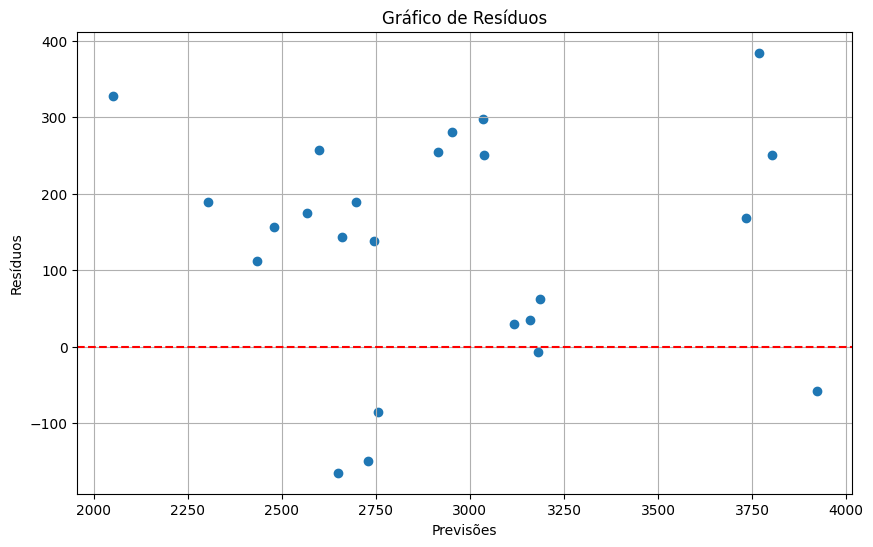

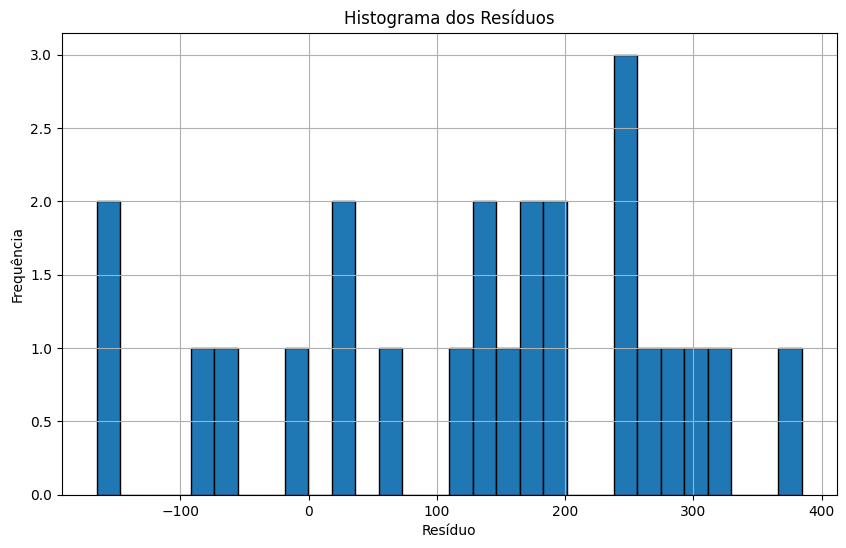

In [10]:
# Gráfico de resíduos
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Gráfico de Resíduos')
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.grid()
plt.show()

# Histograma dos resíduos
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Histograma dos Resíduos')
plt.xlabel('Resíduo')
plt.ylabel('Frequência')
plt.grid()
plt.show()
